In [1]:
import pandas as pd
import numpy as np
import math
import warnings

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import theano
import pymc3 as pm
import arviz as az

In [2]:
plt.rcParams["figure.figsize"] = [8,8]
warnings.filterwarnings(action='ignore')

In [3]:
def lnmkt2price(lnmkt, num_btc=18_400_000):
    '''Calculate the price per BTC based on the total log market value.'''
    return math.exp(lnmkt) / num_btc

# Courtesy Eric J. Ma https://ericmjl.github.io/blog/2018/7/14/ecdfs/
def ecdf(data):
    x, y = np.sort(data), np.arange(1, len(data)+1) / len(data)
    return x, y

In [4]:
# Read the excel file available at https://github.com/100trillionUSD/bitcoin
df = pd.read_excel('bitcoin/sf.xls')
df = df.dropna()
df.head()

,Date,#blocks,#btc,SF,price,market value,ln(SF),ln(value),SF model,model price
10,2009-10-01 02:00:00,2126.0,1311200.0,0.145931,0.000764,1001.680672,-1.924619,6.909435,1665.067161,0.001270
11,2009-11-01 01:00:00,2217.0,1422050.0,0.219854,0.002000,2844.100000,-1.514791,7.953002,7007.762094,0.004928
12,2009-12-01 01:00:00,4048.0,1624450.0,0.166049,0.002000,3248.900000,-1.795472,8.086072,2618.885114,0.001612
13,2010-01-01 01:00:00,5004.0,1874650.0,0.201739,0.002000,3749.300000,-1.600782,8.229324,5183.445996,0.002765
14,2010-02-01 01:00:00,5603.0,2154800.0,0.254596,0.002000,4309.600000,-1.368078,8.368600,11722.363161,0.005440


In [5]:
df.tail()

,Date,#blocks,#btc,SF,price,market value,ln(SF),ln(value),SF model,model price
119,2018-11-01 01:00:00,3870.0,17393787.5,28.125172,4039.0,7.025351e+10,3.336665,24.975376,1.714351e+11,9856.113047
120,2018-12-01 00:00:00,4375.0,17448475.0,24.952438,3692.0,6.441977e+10,3.216972,24.888686,1.126712e+11,6457.364869
121,2019-01-01 00:00:00,4525.0,17505037.5,24.205856,3411.0,5.970968e+10,3.186595,24.812760,1.012862e+11,5786.117256
122,2019-02-01 00:00:00,4125.0,17556600.0,26.644505,3792.0,6.657463e+10,3.282583,24.921589,1.418194e+11,8077.839450
123,2019-03-01 00:00:00,4480.0,17612600.0,24.609896,4000.0,7.045040e+10,3.203149,24.978175,1.073399e+11,6094.495337


In [6]:
# What he uses in the article though may be higher.
halvening_sf = np.log(50)

# Use the log of the values
sf = df['SF'].values
mkt = df['market value'].values

x = np.log(sf)
y = np.log(mkt)

In [7]:
# Do a simple linear regresion

reg = LinearRegression()
reg = reg.fit(x.reshape(-1,1),y.reshape(-1,1))
beta = reg.coef_[0][0]
alpha = reg.intercept_[0]

halvening_mkt_predicted = beta * halvening_sf + alpha
print(f'Alpha: {alpha}, Beta {beta}, LNMKT {halvening_mkt_predicted},  $/BTC {lnmkt2price(halvening_mkt_predicted)}')

Alpha: 14.166721087821085, Beta 3.506719967031347, LNMKT 27.885090272441943,  $/BTC 70068.53054227373


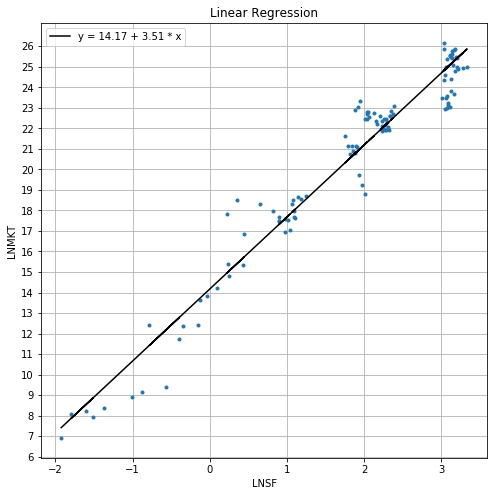

In [8]:
plt.plot(x, y, 'C0.')
_ = plt.plot(x, alpha + beta * x, c='k', label=f'y = {alpha:.2f} + {beta:.2f} * x')
plt.yticks(np.arange(6, 27., 1))
plt.xlabel('LNSF')
plt.ylabel('LNMKT')
plt.title('Linear Regression')
plt.legend()
plt.grid()

In [9]:
# Bayesian linear regression

x_shared = theano.shared(x)

with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta = pm.Normal('beta', mu=0, sd=20)
    epsilon = pm.HalfCauchy('epsilon', beta=10)
    
    mu = alpha + beta * x_shared
    y_likelihood = pm.Normal('y', mu=mu, sd=epsilon, observed=y)
    
    trace = pm.sample(draws=10000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, beta, alpha]
Sampling 4 chains: 100%|██████████| 48000/48000 [00:17<00:00, 2726.33draws/s]


In [10]:
summary = pm.summary(trace)
summary

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,14.164031,0.168454,0.000971,13.841006,14.499193,23405.458065,1.000038
beta,3.507778,0.076854,0.000460,3.355572,3.658055,23367.872353,1.000001
epsilon,1.070568,0.073222,0.000482,0.931595,1.216394,24775.034467,1.000043


In [11]:
alpha_m = summary.loc['alpha']['mean']
beta_m  = summary.loc['beta']['mean']

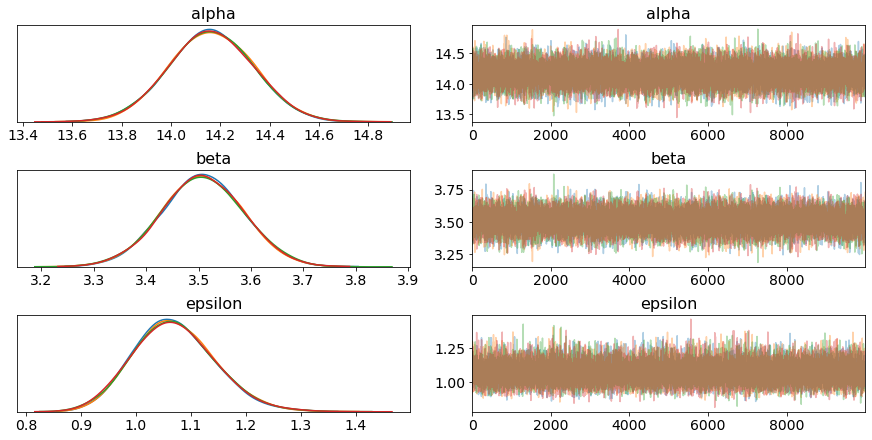

In [12]:
_ = pm.traceplot(trace)

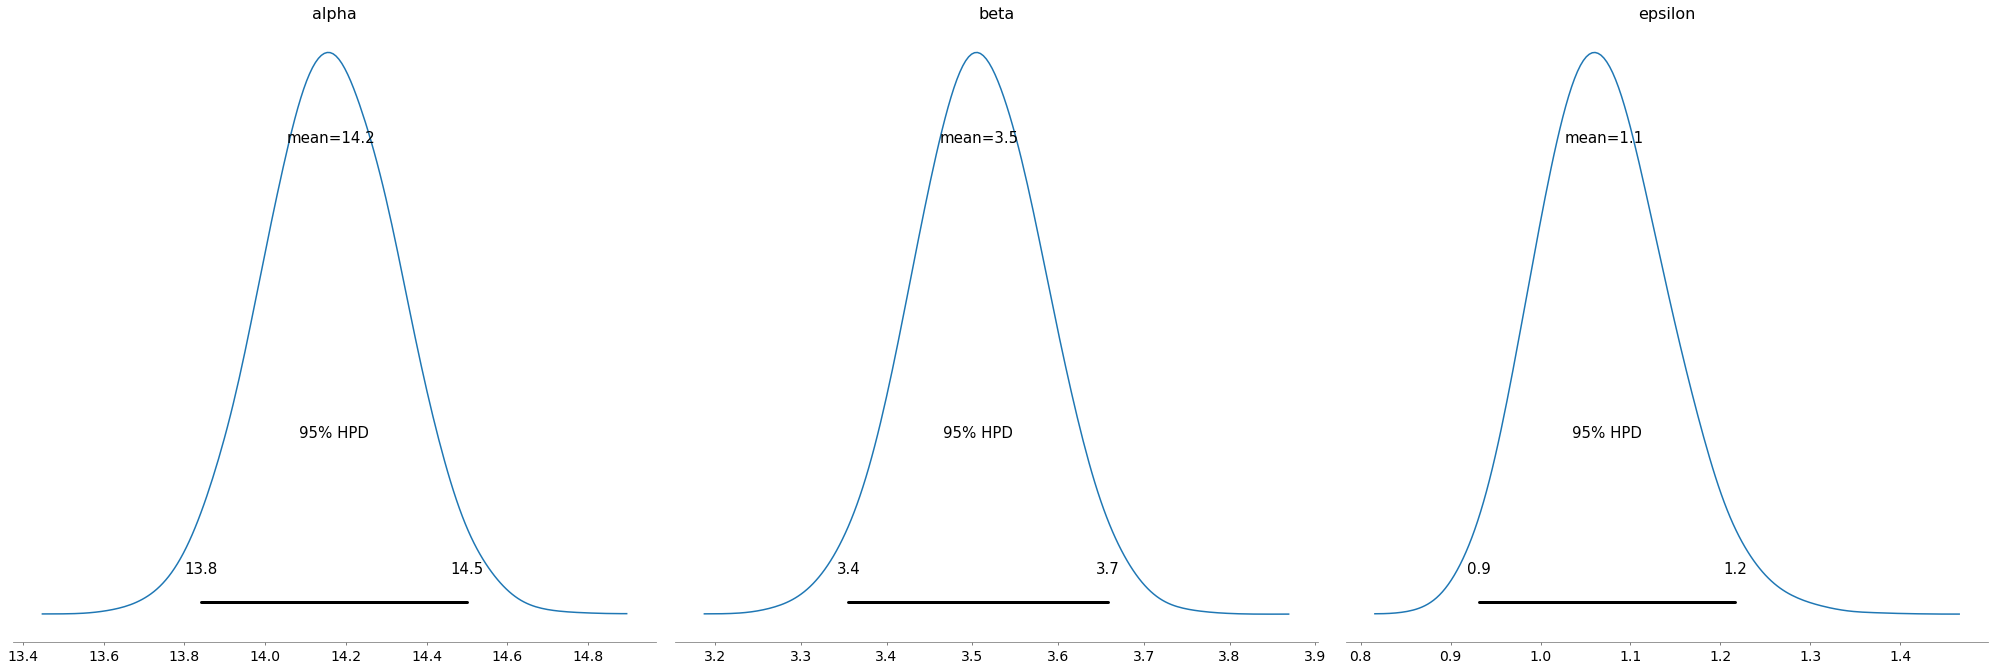

In [13]:
_ = pm.plot_posterior(trace, credible_interval=.95)

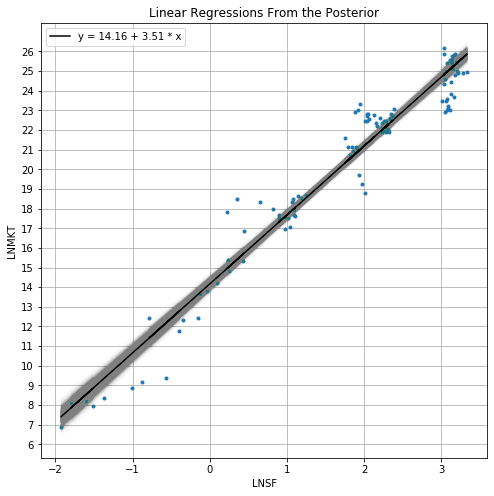

In [14]:
# Plot other possible lines 
plt.plot(x, y, 'C0.')

alpha_m = trace[alpha].mean()
beta_m = trace[beta].mean()

draws = range(0, len(trace[alpha]), 10)
plt.plot(x, trace[alpha][draws] + trace[beta][draws]
         * x[:, np.newaxis], c='gray', alpha=0.005)

plt.plot(x, alpha_m + beta_m * x, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

plt.yticks(np.arange(6, 27., 1))
plt.xlabel('LNSF')
plt.ylabel('LNMKT')
plt.grid()
plt.title("Linear Regressions From the Posterior")
_ = plt.legend()

In [15]:
# Sample from the posterior - extended out to the halvening

nx = np.linspace(-2,4,114)
x_shared.set_value(nx)
ppc_trace = pm.sample_posterior_predictive(trace,
                                     samples=10000,
                                     model=model)

100%|██████████| 10000/10000 [00:08<00:00, 1117.90it/s]


Text(0.5, 1.0, '50% & 95% Credible Intervals')

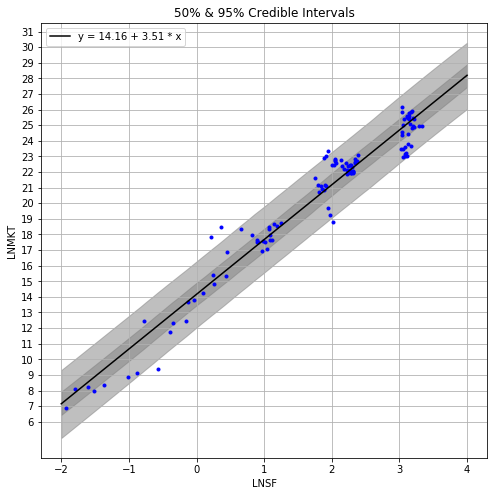

In [16]:
plt.plot(x, y, 'b.')
plt.plot(nx, alpha_m + beta_m * nx, c='k',
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

az.plot_hpd(nx, ppc_trace['y'], credible_interval=0.5, color='gray')
az.plot_hpd(nx, ppc_trace['y'],  credible_interval=0.95, color='gray')

plt.legend()
plt.yticks(np.arange(6, 26., 1))
plt.xlabel('LNSF')
plt.ylabel('LNMKT')
plt.grid()
plt.yticks(np.arange(6, 32, 1))
plt.title("50% & 95% Credible Intervals")

In [17]:
# Get predictions on sf @ halvening

nx = np.zeros_like(x)
nx.fill(halvening_sf)

x_shared.set_value(nx)
ppc_trace = pm.sample_posterior_predictive(trace,
                                     samples=10000,
                                     model=model)

100%|██████████| 10000/10000 [00:08<00:00, 1123.28it/s]


In [18]:
# Print out the mean +- 1 or 2 std and create markdown table.

mkt_preds = ppc_trace['y'].ravel()
ppc_mean = mkt_preds.mean()
ppc_std =  mkt_preds.std()

lbls = ["-2 sd", "-1 sd", "mean", "+1 sd", "+2 sd"]
vals = [ppc_mean - 2 * ppc_std, ppc_mean - 1 * ppc_std, ppc_mean, ppc_mean + 1 * ppc_std, ppc_mean + 2 * ppc_std]
print(vals)
print([lnmkt2price(v) for v in vals])

print("|| LNMKT | $/BTC|")
print("|---|---|---|")
for l,v in zip(lbls,vals):
    print(f'|{l} | {v:.1f} | {(lnmkt2price(v)/ 1000):.1f}k |')

[25.709327317552823, 26.798143801954446, 27.886960286356064, 28.975776770757683, 30.064593255159306]
[7954.285308781179, 23630.241244492245, 70199.68225887803, 208546.13113169363, 619539.6818124118]
|| LNMKT | $/BTC|
|---|---|---|
|-2 sd | 25.7 | 8.0k |
|-1 sd | 26.8 | 23.6k |
|mean | 27.9 | 70.2k |
|+1 sd | 29.0 | 208.5k |
|+2 sd | 30.1 | 619.5k |


In [19]:
# Generate reasonable tick marks

start_mkt = 24
tick_offsets = [start_mkt + o * 2 for o in range(5)]
tick_labels = [f'{t} ({(lnmkt2price(t)/1000.0):.1f}k)' for t in tick_offsets]
print(tick_offsets)
print(tick_labels)

[24, 26, 28, 30, 32]
['24 (1.4k)', '26 (10.6k)', '28 (78.6k)', '30 (580.8k)', '32 (4291.5k)']


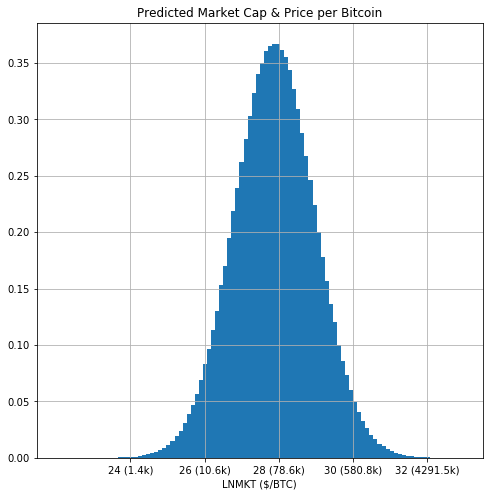

In [20]:
_ = plt.hist(mkt_preds, bins=100, density=True)
_ = plt.xticks(tick_offsets, tick_labels)
plt.grid()
plt.title('Predicted Market Cap & Price per Bitcoin')
_ = plt.xlabel("LNMKT ($/BTC)")

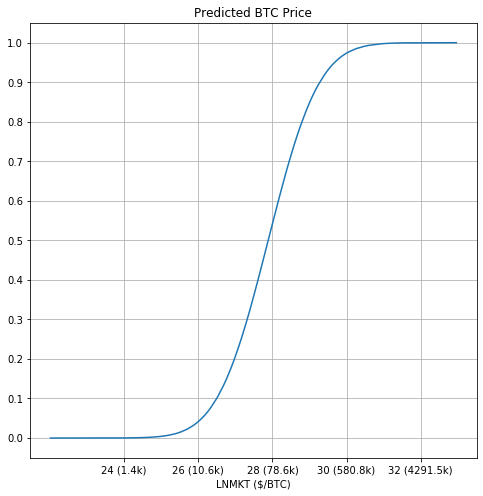

In [21]:
x, y = ecdf(mkt_preds)
plt.plot(x,y)
#plt.xscale('log')
plt.yticks(np.arange(0, 1.1, .1))
plt.grid(True)
plt.title("Predicted BTC Price")
_ = plt.xlabel("LNMKT ($/BTC)")
_ = plt.xticks(tick_offsets, tick_labels)